In [2]:
! pip install transformers nltk pandas numpy matplotlib seaborn wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# load the dataset
news_d = pd.read_csv("train.csv")

print("Shape and Size of News Data:", news_d.shape)
print("News Data columns", news_d.columns)

# by using df.head(), we can immediately familiarize ourselves with the dataset. 
news_d.head()

Shape and Size of News Data: (20800, 5)
News Data columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
#Text Word startistics: min.mean, max and interquartile range
txt_length = news_d.text.str.split().str.len()
txt_length.describe()

#Title statistics 
title_length = news_d.title.str.split().str.len()
title_length.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

1: Unreliable
0: Reliable
Distribution of labels:
label
1    10413
0    10387
Name: count, dtype: int64
label
1    50.0
0    50.0
Name: proportion, dtype: float64


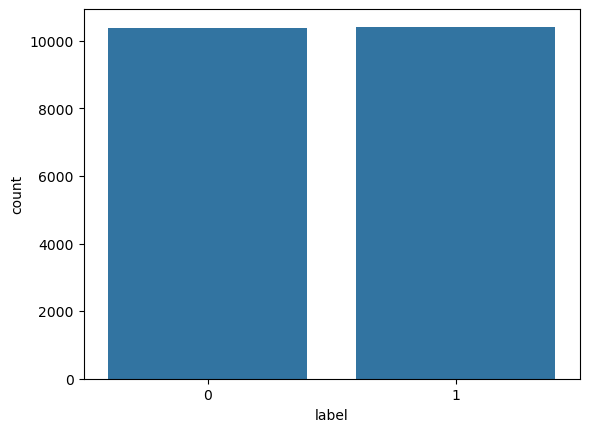

In [6]:
sns.countplot(x="label", data=news_d);
print("1: Unreliable")
print("0: Reliable")
print("Distribution of labels:")
print(news_d.label.value_counts());

print(round(news_d.label.value_counts(normalize=True),2)*100);

In [7]:
# Constants that are used to sanitize the datasets 

column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

# Clean Datasets
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused columns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [8]:
# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["text"] = df.text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
df["title"] = df.title.apply(nltk_preprocess)

# Dataset after cleaning and preprocessing step
df.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


In [17]:
! pip install -U transformers
! pip install -U torch

import torch
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

In [18]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [19]:
news_df = news_d[news_d['text'].notna()]
news_df = news_df[news_df["author"].notna()]
news_df = news_df[news_df["title"].notna()]

In [20]:
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []
  for i in range(len(df)):
    text = df["text"].iloc[i]
    label = df["label"].iloc[i]
    if include_title:
      text = df["title"].iloc[i] + " - " + text
    if include_author:
      text = df["author"].iloc[i] + " : " + text
    if text and label in [0, 1]:
      texts.append(text)
      labels.append(label)
  return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

In [21]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

14628 14628
3657 3657


In [22]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [23]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [24]:
# load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    print(confusion_matrix(labels, preds))
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [26]:
! pip install -U accelerate transformers
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=300,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    eval_strategy="steps",          # evaluate each `logging_steps`
    learning_rate=1e-5,             # learning rate
    metric_for_best_model="f1",
    greater_is_better=True,
)

In [27]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # stop if no improvement for 3 evals
)

In [28]:
# train the model
trainer.train()

c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.589000,0.318867,0.906207,0.897304,0.884250,0.890730
400,0.103000,0.005551,0.999180,0.998736,0.999367,0.999052
600,0.008700,0.008015,0.998633,0.998734,0.998102,0.998418
800,0.014700,0.010904,0.998086,0.997472,0.998102,0.997787
1000,0.012300,0.013211,0.997266,0.998098,0.995572,0.996833


[[1916  160]
 [ 183 1398]]


c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[2074    2]
 [   1 1580]]


c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[2074    2]
 [   3 1578]]


c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[2072    4]
 [   3 1578]]


c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[2073    3]
 [   7 1574]]


TrainOutput(global_step=1000, training_loss=0.1455344114303589, metrics={'train_runtime': 21670.2315, 'train_samples_per_second': 2.7, 'train_steps_per_second': 0.27, 'total_flos': 2631110553600000.0, 'train_loss': 0.1455344114303589, 'epoch': 0.683526999316473})

In [29]:
trainer.evaluate()


c:\Users\quang\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[2074    2]
 [   1 1580]]


{'eval_loss': 0.005551148671656847,
 'eval_accuracy': 0.9991796554552912,
 'eval_precision': 0.9987357774968394,
 'eval_recall': 0.9993674889310563,
 'eval_f1': 0.9990515333544103,
 'eval_runtime': 1041.7899,
 'eval_samples_per_second': 3.51,
 'eval_steps_per_second': 0.176,
 'epoch': 0.683526999316473}

In [33]:
# saving the fine tuned model & tokenizer
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('fake-news-bert-base-uncased\\tokenizer_config.json',
 'fake-news-bert-base-uncased\\special_tokens_map.json',
 'fake-news-bert-base-uncased\\vocab.txt',
 'fake-news-bert-base-uncased\\added_tokens.json',
 'fake-news-bert-base-uncased\\tokenizer.json')

In [31]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "Reliable",
        1: "Fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

In [4]:
real_news = """
Keiser Report: Trump is USA's antique hero. Clinton will be next president,nan,"Trump is USA's antique hero. Clinton will be next president 08.11.2016 | Source: AP photo FBI Director James Comey said on November 6 that his department would not be criminally charging Hillary Clinton for revelations found in her email correspondence. Earlier, however, the FBI had flagged Clinton's email case as a file of high priority. It was said that the FBI had collected a lot of evidence. All of a sudden, it was announced that Clinton would be cleared. Pravda.Ru asked political scientist and publicist Leonid Krutakov to comment on such a development. ""Was it a though-out move to show that Clinton is not guilty?"" ""Did you expect a criminal case against Clinton right before the election? I thought of such a plan if Trump were winning, but now that they have cleared her name, it means that Hillary Clinton will win the election. One can be sure for 100 percent that Hillary Clinton will be the next President of the United States of America. ""I do not think that the FBI Director made that decision independently. This is a political figure, this is a job to which people are appointed by someone else. It is stupid to believe that one FBI director will stand up against the whole elite that prints money and runs business and international politics. The times of ancient heroes have passed. Trump has tried to become one. He has proclaimed a new era, not only in America but in the world, and the electorate that has consolidated around Trump will not go anywhere after the election. ""One needs another war and another threat to America to make Trump's electorate change their mind. As we remember, George W. Bush won the election in no less controversial election battles, when votes in Florida were recounted manually. We remember what happened afterwards - we had September 11, wars in Afghanistan and Iraq, and Bush immediately scored 96 percent of support of the nation. History repeats itself."" Pravda.Ru Read article on the Russian version of Pravda.Ru What does Hillary Clinton like about Putin?"
"""
get_prediction(real_news, convert_to_label=True)

NameError: name 'get_prediction' is not defined